# Text Module Tutorial 2: Keyword Classification

In this tutorial, we demonstrate how to perform a keyword-based classification of O&M records. This method is quick and straightforward, but has limited accuracy. To see a more involved machine learning approach, refer to text module tutorial 3.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# pvops functionality
from pvops.text import utils as text_utils
from pvops.text import nlp_utils as text_nlp_utils
from pvops.text import preprocess as text_preprocess
from pvops.text import classify as text_classify
from pvops.text import visualize as text_visualize

### Preprocessing

See text module tutorial 1 for more information on preprocessing steps. Here, we quickly run through them.

In [2]:
# read in dataset
df = pd.read_csv('example_data/example_ML_ticket_data.csv')

# perform asset label remapping
remapping_df = pd.read_csv('example_data/remappings_asset.csv')
remapping_df['out_'] = remapping_df['out_'].replace({'met station': 'met',
                                                     'energy storage': 'battery',
                                                     'energy meter': 'meter'})
remapping_col_dict = dict(attribute_col='Asset', 
                          remapping_col_from='in',
                          remapping_col_to='out_')
df = text_utils.remap_attributes(df, remapping_df, remapping_col_dict, allow_missing_mappings=True)

# let's only keep asset labels which have more than one instance in the dataset
label_counts = df.value_counts('Asset')
labels_with_multiple_occurrences = label_counts.loc[label_counts > 1].index
df = df.loc[df['Asset'].isin(labels_with_multiple_occurrences)]

# bulid a custom set of stopwords
stopwords = text_nlp_utils.create_stopwords(lst_add_words=['dtype', 'say', 'length', 'object', 'u', 'ha', 'wa'])

# run our preprocessing function to clean up the text data and prepare it for ML
col_dict = dict(data='CompletionDesc',
                eventstart='Date_EventStart',
                save_data_column='CleanDesc',
                save_date_column='ExtractedDates')
df = text_preprocess.preprocessor(df, stopwords, col_dict)

### Keyword-based classification

Now, let's tokenize our dataset:

In [3]:
df['CleanDescTokenized'] = df['CleanDesc'].apply(text_preprocess.regex_tokenize)
df.head()

,Date_EventStart,Date_EventEnd,Asset,CompletionDesc,Cause,ImpactLevel,randid,ExtractedDates,CleanDesc,CleanDescTokenized
0,8/16/2018 9:00,8/22/2018 17:00,combiner,cb 1.18 was found to have contactor issue woul...,0000 - Unknown.,Underperformance,38,[],cb found contactor issue would close contactor...,"[cb, found, contactor, issue, would, close, co..."
1,9/17/2018 18:25,9/18/2018 9:50,transformer,self resolved. techdispatched: no,004 - Under voltage.,Underperformance,46,[],self resolved techdispatched,"[self, resolved, techdispatched]"
2,8/26/2019 9:00,11/5/2019 17:00,facility,"all module rows washed, waiting for final repo...",0000 - Unknown,Underperformance,62,[2019-09-01 09:00:00],module rows washed waiting final report sun power,"[module, rows, washed, waiting, final, report,..."
3,11/14/2017 7:46,11/14/2017 8:35,inverter,14 nov: we were alerted that e-c3-1 had faulte...,019 - Unplanned outage/derate.,Underperformance,54,"[2017-11-14 07:46:00, 2017-03-01 07:46:00]",nov alerted e c faulted upon investigation not...,"[nov, alerted, e, c, faulted, upon, investigat..."
4,4/27/2019 9:00,5/2/2019 17:00,facility,assessed condition filters all inverters. litt...,.,NaN,45,[],assessed condition filters inverters little cl...,"[assessed, condition, filters, inverters, litt..."


We have two csv files that help us interpret PV-relevant terms and abbreviations:

In [4]:
# replace terms
pv_reference_df = pd.concat([pd.read_csv('example_data/mappings_equipment.csv'),
                             pd.read_csv('example_data/mappings_pv_terms.csv')])
reference_col_dict = dict(reference_col_from='in', reference_col_to='out_')
pv_reference_df.head()

,in,out_
0,combiner,combiner
1,comb,combiner
2,cb,combiner
3,battery,battery
4,bess,battery


Here, we use the above dataframe to make a "prediction" of what the asset is. For instance, if "combiner", "comb", "cb", etc. appears as a token, we predict "combiner" as the asset. Note that sometimes multiple assets are mentioned in a single ticket. The resulting entries are printed out below when the function `get_attributes_from_keywords` is called, and the rows corresponding to such cases are duplicated, each with a different value for `'Keyword_Asset'`.

In [5]:
# where to take tokenized data from, and where to write out "prediction"
data_predicted_dict = dict(data='CleanDescTokenized', predicted_col='Keyword_Asset')

df = text_classify.get_attributes_from_keywords(df, data_predicted_dict, pv_reference_df, reference_col_dict)
df.head()

25 entries had multiple keywords of interest. Reference: Index([ 7,  9, 11, 13, 16, 17, 28, 31, 32, 35, 36, 38, 42, 44, 48, 52, 54, 56,
       57, 61, 73, 76, 78, 87, 96],
      dtype='int64') in original dataframe.


,Date_EventStart,Date_EventEnd,Asset,CompletionDesc,Cause,ImpactLevel,randid,ExtractedDates,CleanDesc,CleanDescTokenized,Keyword_Asset
0,8/16/2018 9:00,8/22/2018 17:00,combiner,cb 1.18 was found to have contactor issue woul...,0000 - Unknown.,Underperformance,38,[],cb found contactor issue would close contactor...,"[cb, found, contactor, issue, would, close, co...",combiner
1,9/17/2018 18:25,9/18/2018 9:50,transformer,self resolved. techdispatched: no,004 - Under voltage.,Underperformance,46,[],self resolved techdispatched,"[self, resolved, techdispatched]",NaN
2,8/26/2019 9:00,11/5/2019 17:00,facility,"all module rows washed, waiting for final repo...",0000 - Unknown,Underperformance,62,[2019-09-01 09:00:00],module rows washed waiting final report sun power,"[module, rows, washed, waiting, final, report,...",module
3,11/14/2017 7:46,11/14/2017 8:35,inverter,14 nov: we were alerted that e-c3-1 had faulte...,019 - Unplanned outage/derate.,Underperformance,54,"[2017-11-14 07:46:00, 2017-03-01 07:46:00]",nov alerted e c faulted upon investigation not...,"[nov, alerted, e, c, faulted, upon, investigat...",inverter
4,4/27/2019 9:00,5/2/2019 17:00,facility,assessed condition filters all inverters. litt...,.,NaN,45,[],assessed condition filters inverters little cl...,"[assessed, condition, filters, inverters, litt...",system


Now, let's score our classification. We can consider those with no asset found as "other".

In [6]:
fraction_with_labels = df['Keyword_Asset'].notnull().mean()

# replace missing label with 'other'
df_clean = df.copy()
df_clean['Keyword_Asset'] = df_clean['Keyword_Asset'].fillna('other')

# some index labels have multiple "guesses", so we need to group by the index first and compute the average accuracy for each index label
score_by_label = df_clean.groupby(level=0).apply(lambda x: accuracy_score(y_true=x['Asset'], y_pred=x['Keyword_Asset']))

# now, we can compute the overall accuracy
score = score_by_label.mean()
msg = f'{fraction_with_labels:.1%} of entries had a keyword of interest. Keyword-based classification was {score:.1%} accurate.'
print(msg)

73.0% of entries had a keyword of interest. Keyword-based classification was 26.8% accurate.


We can see this method has limitations--it requires a known keyword to be present to make a prediction, and even when a label is able to be predicted, the accuracy is poor. We can understand this further by plotting a confusion matrix:

NOTE: Predicted values
['system', 'outage', 'switchgear', 'communication', 'recloser', 'grid', 'wiring', 'meter', 'solar', 'preventative_maintence']
had no actual values in the dataset.


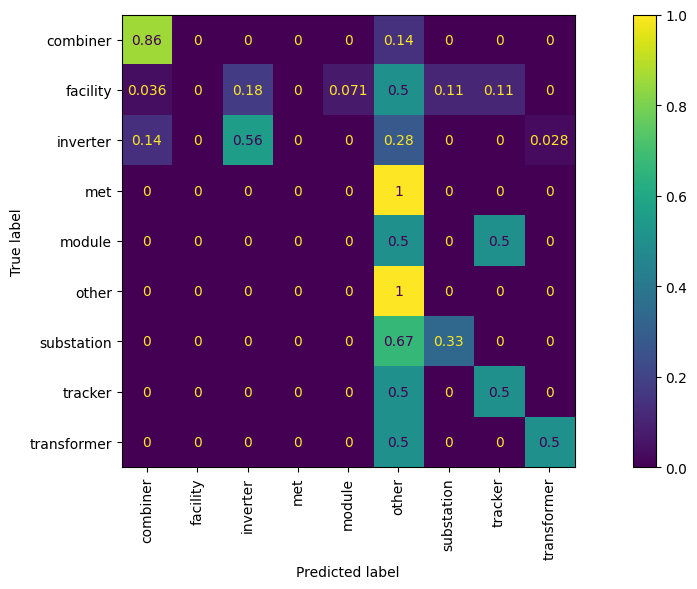

In [7]:
data_predicted_dict['attribute_col'] = 'Asset'
_, ax = plt.subplots(figsize=(12,6))
text_visualize.visualize_classification_confusion_matrix(df_clean, data_predicted_dict, ax=ax);

The more accurate the model is, the more the values in the confusion matrix will be concentrated along the diagonal. We can see that the model correctly identifies all "other" labels and most of the "combiner" labels, but the accuracy on other labels is rather poor.

In text module tutorial 3, we will improve on this accuracy by leveraging machine-learning based approaches.